# Prognosis of cardiovascular diseases
## (with 400k adults 2020)

##### Data Visualization in Tableau Public:
https://public.tableau.com/app/profile/anton8444/viz/ThehealthstatusofAmericans2020/Dashboard1

#### Dataset:
https://www.cdc.gov/brfss/index.html

##### Preprocessing data in the previous file.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from IPython.display import Image

In [6]:
df = pd.read_csv('heart_des_data.csv')

In [7]:
df.head(3)

,_SEX,_AGE80,_TOTINDA,GENHLTH,CVDSTRK3,DIABETE4,LASTDEN4,_EDUCAG,_CHLDCNT,_SMOKER3,...,NEVMRRD,SEPRTD,UNMCOUPL,WIDWD,AMRNTV,ASIAN,BLACK,HISPAN,OTHRRACE,WHITE
0,0.0,56.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.000000,...,0,0,0,0,0,0,0,0,0,1
1,0.0,65.0,1.0,3.0,0.0,0.0,1.0,4.0,1.0,3.634669,...,0,0,0,1,0,0,1,0,0,0
2,0.0,65.0,1.0,3.0,0.0,0.0,1.0,3.0,1.0,4.000000,...,0,0,0,0,0,0,1,0,0,0


## Work with model
### Logistic regression (Base model)

In [108]:
y = df['_MICHD']
X = df.drop(['_MICHD'], axis = 1)

In [109]:
scaler = MinMaxScaler()                     # Normalizing the values
X = pd.DataFrame(scaler.fit_transform(X),
            columns = X.columns, index = X.index) 

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 97)      # Split data for train & test sets

In [111]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print('train score:',model.score(X_test, y_test))
print('test score:',model.score(X_train, y_train))
p_test = model.predict_proba(X_test)[:,-1]
print('roc auc:', roc_auc_score(y_test, p_test))
y_pred = model.predict(X_test)
print('matrix:', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train score: 0.9156425673779373
test score: 0.915191718909462
roc auc: 0.8358545680409865
matrix: [[106730    781]
 [  9138    934]]
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96    107511
         1.0       0.54      0.09      0.16     10072

    accuracy                           0.92    117583
   macro avg       0.73      0.54      0.56    117583
weighted avg       0.89      0.92      0.89    117583



##### Poor f1 score for predicting CVD (cardiovascular disease) depends on target classes being imbalanced (10:1).

### Work with Class imbalance

In [112]:
df['_MICHD'][(df['CVDSTRK3'] == 1) & (df['_MICHD'] ==0)].count()

9552

##### Combine stroke and heart attack to predict cardiovascular disease, this gives 9552 cases.

In [ ]:
df["TARGET"] = df["CVDSTRK3"] + df["_MICHD"]
df = df.replace({'TARGET':{2:1}})

In [127]:
df = df.drop(['_MICHD', 'CVDSTRK3'], axis = 1)
df.columns

Index(['_SEX', '_AGE80', '_TOTINDA', 'GENHLTH', 'DIABETE4', 'LASTDEN4',
       '_EDUCAG', '_CHLDCNT', '_SMOKER3', '_URBSTAT', 'BMI_LOG', 'SLEEP_LOG',
       'DIVRSD', 'MARRD', 'NEVMRRD', 'SEPRTD', 'UNMCOUPL', 'WIDWD', 'AMRNTV',
       'ASIAN', 'BLACK', 'HISPAN', 'OTHRRACE', 'WHITE', 'TARGET'],
      dtype='object')

##### Use RandomOverSampler() to oversample the minority class.

In [128]:
y = df['TARGET']
X = df.drop(['TARGET'], axis = 1)

In [129]:
scaler = MinMaxScaler()                     # Normalizing the values
X = pd.DataFrame(scaler.fit_transform(X),
            columns = X.columns, index = X.index) 

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 97)      # Split data for train & test sets

In [131]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [132]:
model = LogisticRegression(max_iter=10000)      # check LR for RandomOverSampler()
model.fit(X_resampled, y_resampled)
print('train score:', model.score(X_test, y_test))
print('test score:', model.score(X_resampled, y_resampled))
p_test = model.predict_proba(X_test)[:,-1]
print('roc auc:', roc_auc_score(y_test, p_test))
y_pred = model.predict(X_test)
print('matrix:', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train score: 0.7267377086823775
test score: 0.7497297186616979
roc auc: 0.8209794034297182
matrix: [[75332 29279]
 [ 2852 10120]]
              precision    recall  f1-score   support

         0.0       0.96      0.72      0.82    104611
         1.0       0.26      0.78      0.39     12972

    accuracy                           0.73    117583
   macro avg       0.61      0.75      0.61    117583
weighted avg       0.89      0.73      0.78    117583



##### The f1 score for the Target improved from 0.16 to 0.39.

### DecisionTreeClassifier

In [116]:
from sklearn import tree

##### Find the best options for DecisionTreeClassifier.

In [135]:
from sklearn.model_selection import GridSearchCV      # find best params for tree
params = {'max_leaf_nodes': list(range(80, 110)), 'min_samples_split': [2, 3, 4], 'max_depth': list(range(7,13))}
grid_search_cv = GridSearchCV(tree.DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)
grid_search_cv.fit(X_resampled, y_resampled)
grid_search_cv.best_estimator_

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


DecisionTreeClassifier(max_depth=9, max_leaf_nodes=108, random_state=42)

In [136]:
model = tree.DecisionTreeClassifier(max_depth=9, max_leaf_nodes=108, random_state=42)
model.fit(X_resampled, y_resampled)
print('train score:',model.score(X_resampled, y_resampled))
print('test score:',model.score(X_test, y_test))
p_test = model.predict_proba(X_test)[:,-1]
print('roc auc:', roc_auc_score(y_test, p_test))
y_pred = model.predict(X_test)
print('matrix:', confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

train score: 0.7529935705802858
test score: 0.713513007832765
roc auc: 0.8170796975894186
matrix: [[73599 31012]
 [ 2674 10298]]
              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81    104611
         1.0       0.25      0.79      0.38     12972

    accuracy                           0.71    117583
   macro avg       0.61      0.75      0.60    117583
weighted avg       0.89      0.71      0.77    117583



#### Visualize a decision tree

In [ ]:
!pip install dtreeviz             
from dtreeviz.trees import *

In [137]:
viz = dtreeviz(model, 
               X_resampled,
               y_resampled,
               target_name = 'disease risk',
               feature_names = X.columns, 
               class_names = ['0', '1'])
viz

Output hidden; open in https://colab.research.google.com to view.

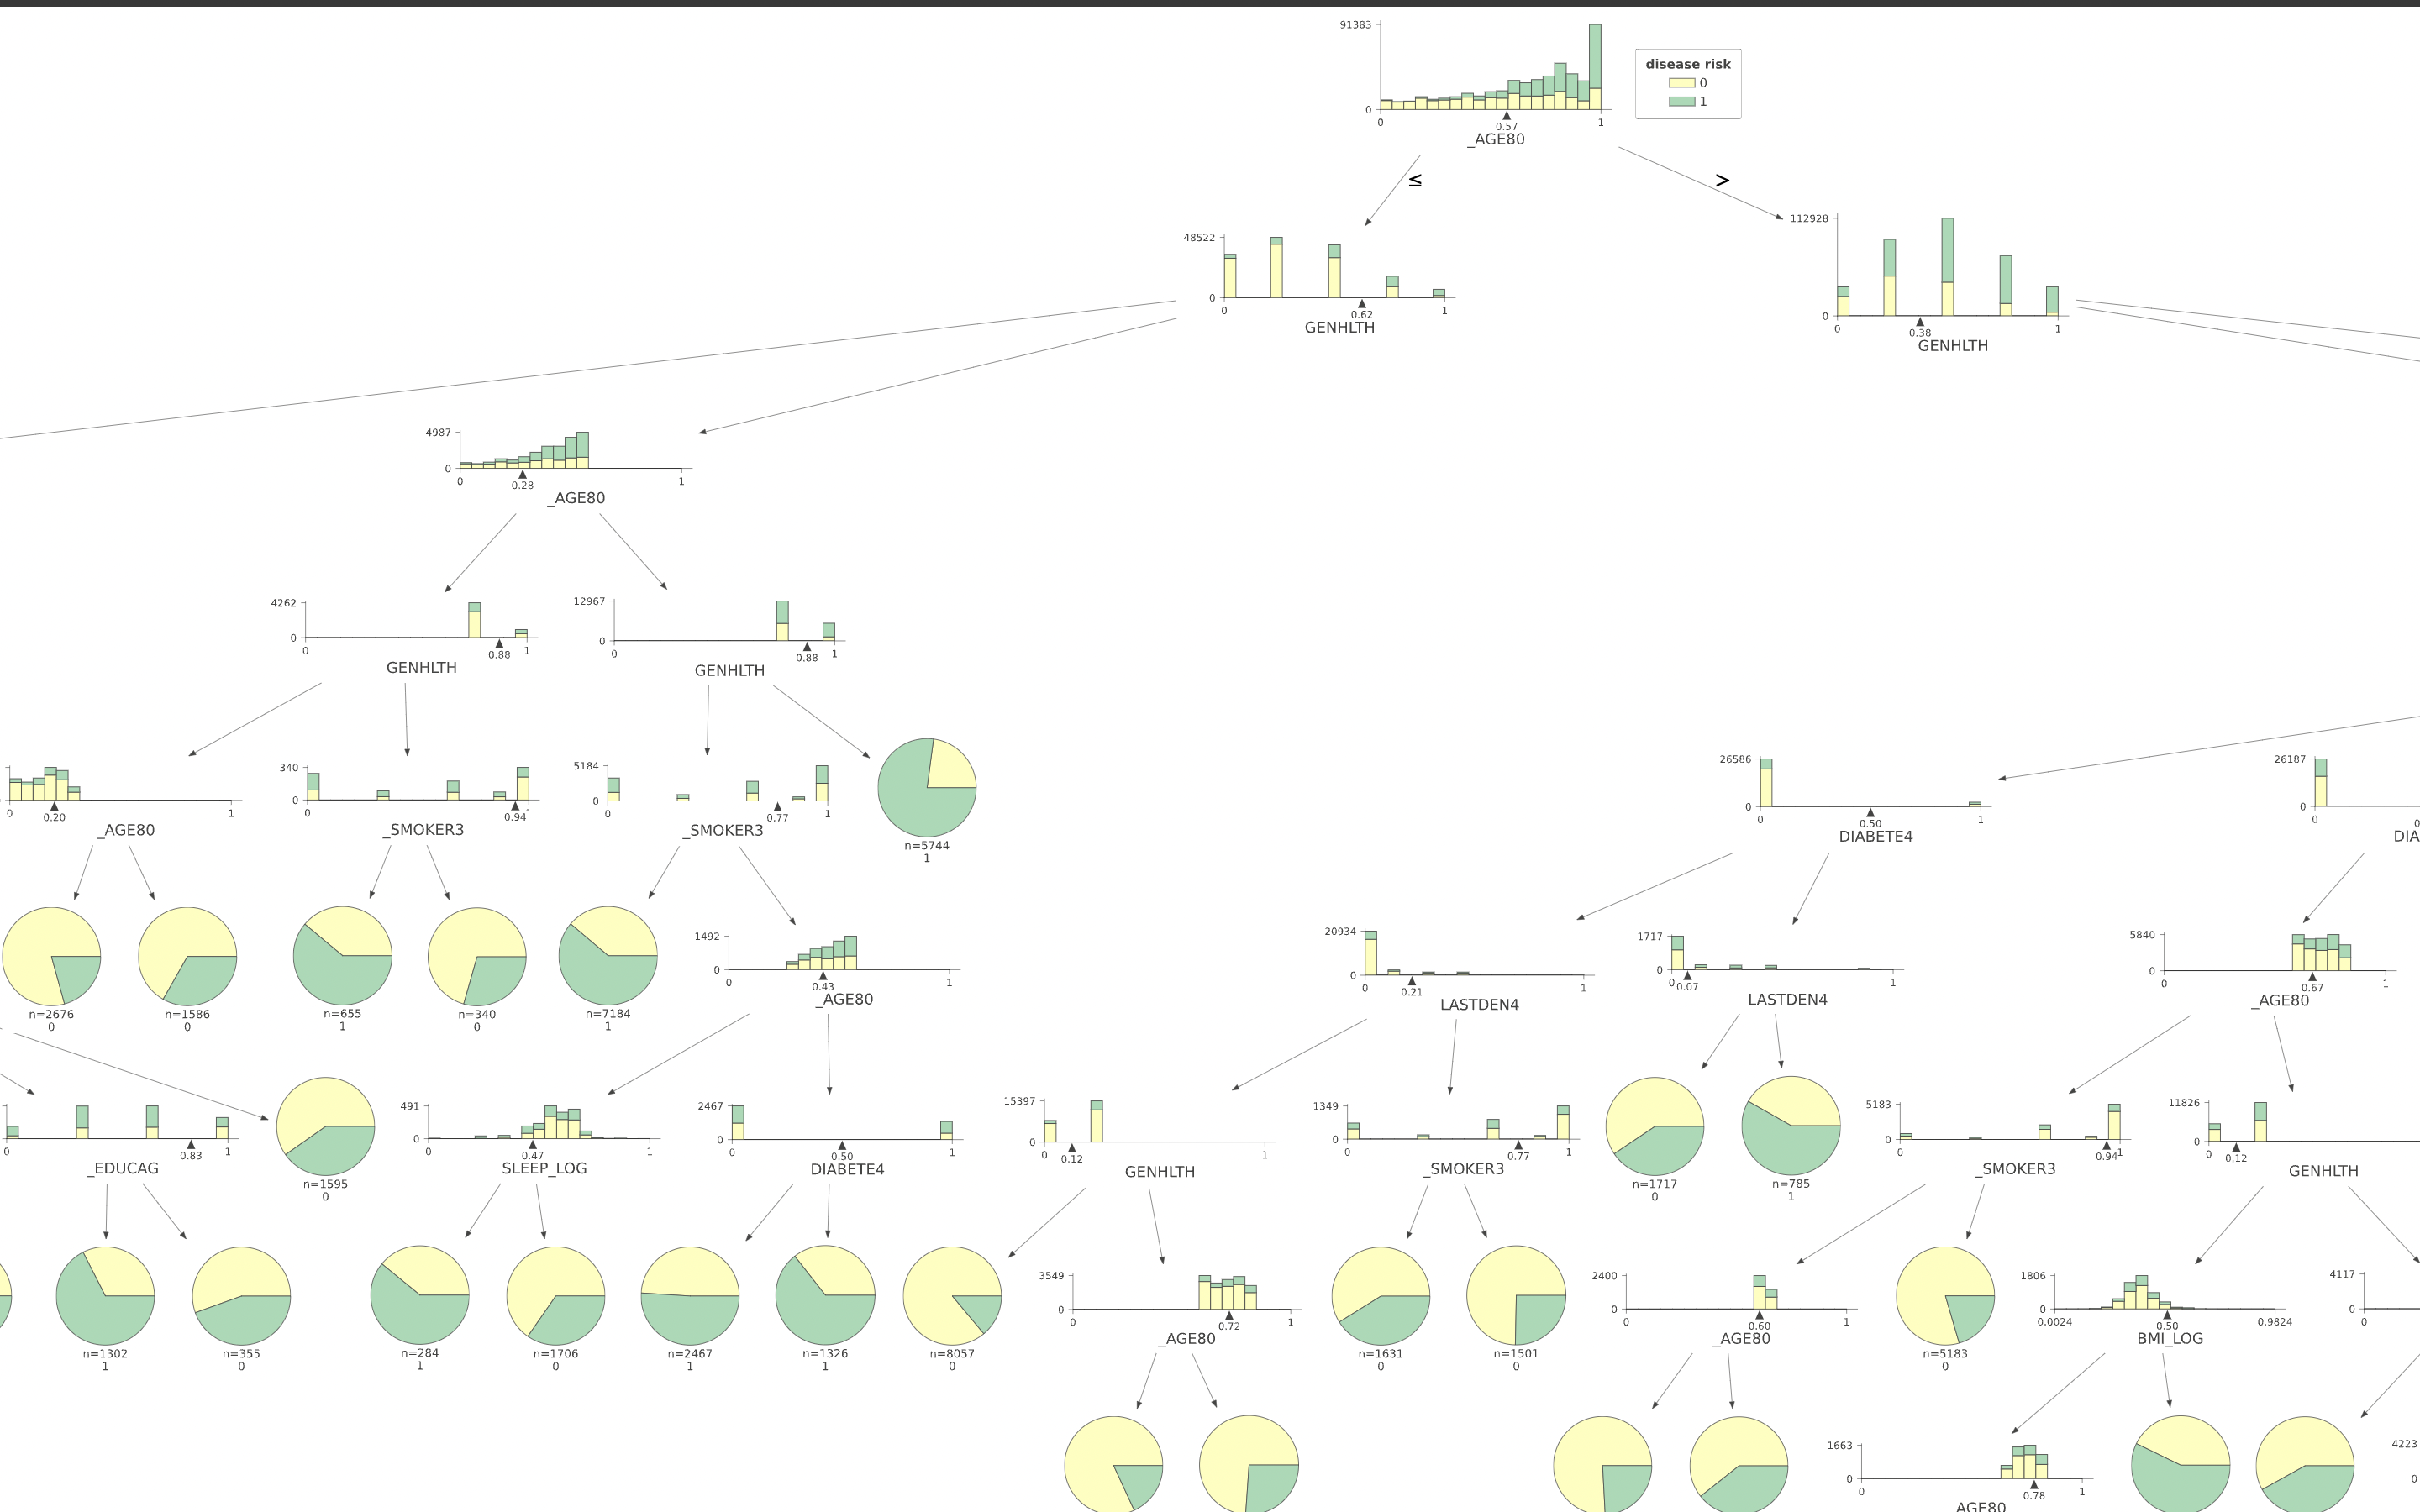

In [14]:
Image('dtreeviz.png')

## Conclusion

##### This model can be used for rapid screening of people prone to stroke and heart attack, despite more 30 thousand false predictions of the disease, while at the same time there are few false predictions about the absence of the disease (2,6k).
##### The model is quite comfortable, there are non-invasive indicators that can be examined at home or by phone.